In [1]:
import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(777)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(745)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(1234455)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Activation
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [3]:
dataset = pd.read_csv(r'df_prova.csv', parse_dates = ['Data'])
dataset = dataset['PUN'].values

Training_set = dataset[:26112]
Test_set = dataset[26112:]



Training_set = Training_set.reshape(-1, 1)
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(Training_set)

X_train = []
y_train = []
for i in range(24,26112):
    X_train.append(training_set_scaled[i-24:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [4]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.1))
# Second LSTM layer
regressor.add(LSTM(units=150, return_sequences=True))
regressor.add(Dropout(0.1))
# Third LSTM layer
regressor.add(LSTM(units=150, return_sequences=True))
regressor.add(Dropout(0.1))
# Fourth LSTM layer
regressor.add(LSTM(units=150))
regressor.add(Dropout(0.1))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=38)

Epoch 1/50
26088/26088 [==============================] - 49s 2ms/step - loss: 0.0051
Epoch 2/50
26088/26088 [==============================] - 47s 2ms/step - loss: 0.0013
Epoch 3/50
26088/26088 [==============================] - 47s 2ms/step - loss: 0.0011
Epoch 4/50
26088/26088 [==============================] - 47s 2ms/step - loss: 9.7465e-04
Epoch 5/50
26088/26088 [==============================] - 47s 2ms/step - loss: 9.0067e-04
Epoch 6/50
26088/26088 [==============================] - 47s 2ms/step - loss: 8.5325e-04
Epoch 7/50
26088/26088 [==============================] - 47s 2ms/step - loss: 8.1515e-04
Epoch 8/50
26088/26088 [==============================] - 47s 2ms/step - loss: 7.8850e-04
Epoch 9/50
26088/26088 [==============================] - 47s 2ms/step - loss: 7.5128e-04
Epoch 10/50
26088/26088 [==============================] - 47s 2ms/step - loss: 7.4480e-04
Epoch 11/50
26088/26088 [==============================] - 47s 2ms/step - loss: 7.2975e-04
Epoch 12/50
26088/26

In [5]:
d = pd.read_csv(r'df_prova.csv', parse_dates = ['Data'])
d = d['PUN']
inputs = d[len(d) - len(Test_set)-24:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [6]:
X_test = []
for i in range(24,192):
    X_test.append(inputs[i-24:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_test_price = regressor.predict(X_test)
predicted_test_price = sc.inverse_transform(predicted_test_price)

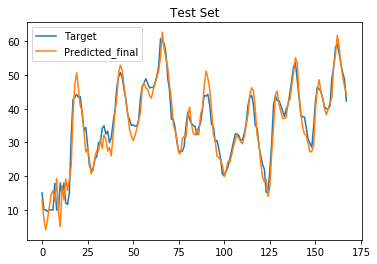

In [7]:
plt.plot(Test_set, label = 'Target')
plt.plot(predicted_test_price, label = 'Predicted_final')
plt.title('Test Set')
plt.legend()
plt.savefig('testLSTM_2.png')

In [8]:
print('MAE: ', np.round(mean_absolute_error(Test_set, predicted_test_price), 3))
print('RMSE: ', np.round(math.sqrt(mean_squared_error(Test_set, predicted_test_price)), 3))
print('MAPE: ', np.round(math.sqrt(mean_absolute_percentage_error(Test_set, predicted_test_price)), 3))

MAE:  2.489
RMSE:  3.242
MAPE:  7.127


In [9]:
inputs = d[:len(Training_set)+24].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [10]:
X_train = []
for i in range(24,26136):
    X_train.append(inputs[i-24:i,0])
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 24 ,1))
predicted_train_price = regressor.predict(X_train)
predicted_train_price = sc.inverse_transform(predicted_train_price)

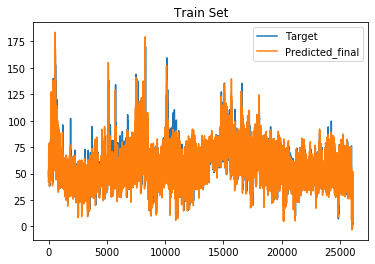

In [11]:
plt.plot(Training_set, label = "Target")
plt.plot(predicted_train_price, label = "Predicted_final")
plt.title('Train Set')
plt.legend()
plt.savefig('TrainLSTM_2.png')

In [12]:
print('MAE: ', np.round(mean_absolute_error(Training_set, predicted_train_price),3))
print('RMSE: ', np.round(math.sqrt(mean_squared_error(Training_set, predicted_train_price)), 3))
print('MAPE: ', np.round(math.sqrt(mean_absolute_percentage_error(Training_set, predicted_train_price)), 3))

MAE:  6.712
RMSE:  9.778
MAPE:  3.6
